In [1]:
import numpy as np
import xarray as xr

import sys
sys.path.append(r'/home/ch23/ML-BEES_yk/ML-BEES-eval/eval_utilities')
from spatial_temporal_metrics import Metrics
import visualization

/data/conda/envs/ailand/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
ecland_eval = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2021", "2022"))  
# train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr")  # Europe subset
# load the ailand data as mod

ailand_eval = xr.open_zarr("/data/ch23/data_ch23/xgbosst_train_2010_2019_val_2020_2020_est_50_hist.zarr")

eval_metrics_acc=xr.open_zarr("/data/ch23/evalution_results/xgbosst_train_2010_2019_val_2020_2020_est_50_hist/spatial/acc.zarr")

In [4]:
# load example in-situ data

insitu_ismn_2022 = xr.open_dataset('/data/insitu_data/soil_ismn_nc/soil_ismn_2022.nc')

insitu_ismn_2022_2 = xr.open_dataset('/data/insitu_data/soil_data_ismn/soil_ismn_2022.nc')

NameError: name 'ailand_eval_2022' is not defined

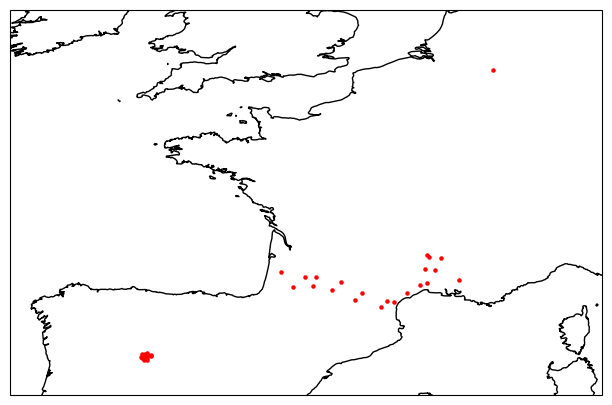

In [5]:
# visualize the grid points on the map from ailand output

import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF file
file_path = '/data/insitu_data/soil_ismn_nc/soil_ismn_2022.nc'
dataset = nc.Dataset(file_path)

# Extract latitude and longitude data
latitudes = dataset.variables['lat'][:]
longitudes = dataset.variables['lon'][:]

# Plotting the grid points on a map
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-10, 10, 40, 53], crs=ccrs.PlateCarree())

# Scatter plot of the grid points
plt.scatter(longitudes, latitudes, color='red', s=5, transform=ccrs.PlateCarree())

(ailand_eval_2022
 .data
 .isel(time=0)
 .sel(variable="swvl1").to_dataset()
 .plot.scatter(x="lon", y="lat", hue="data", s=10, edgecolors="none", 
               ax=ax, transform=ccrs.PlateCarree(), label='Ailand Eval Points',vmin=0,vmax=1)
)


# Add gridlines and title
ax.gridlines(draw_labels=True)
plt.title('Grid Points from NetCDF File')

# Show the plot
plt.show()

In [157]:
ailand_eval_2022

<xarray.Dataset> Size: 376MB
Dimensions:   (time: 1335, x: 10051, variable: 7)
Coordinates:
    lat       (x) float32 40kB 70.94 70.72 70.72 70.72 ... 34.07 34.07 34.07
    lon       (x) float32 40kB 28.31 23.0 25.0 28.0 ... -1.067 -0.7115 -0.3557
  * time      (time) datetime64[ns] 11kB 2022-01-01 ... 2022-11-30T12:00:00
  * variable  (variable) <U5 140B 'swvl1' 'swvl2' 'swvl3' ... 'stl3' 'snowc'
  * x         (x) int32 40kB 15653 16004 16006 16009 ... 128482 128483 128484
Data variables:
    data      (time, x, variable) float32 376MB dask.array<chunksize=(274, 1257, 1), meta=np.ndarray>

In [6]:
# find the close grid points to the in-situ 

def find_nearest_idx(
    arr1: np.ndarray,
    arr2: np.ndarray,
    val1: float,
    val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second arrat
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int; and the minimum distance by lat and lon
    """
    return (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin(), (np.abs(arr1 - val1) + np.abs(arr2 - val2)).min()


In [7]:
# start evaluation only using the nearest points from the ailand data with insitu data
# only 2022 from ailand data -- corresponding to the in-situ year
# only compare swvl1/2/3 and stl1/2/3

# preprocess the dataset 
# 1. ailand data select only 2022
# 2. in-situ data select only 2022 until 11-30, and groupby to 6hours
# SOME OBS data are simply zero

# Group the data into 6-hour means
insitu_2022 = xr.open_dataset(file_path)

insitu_2022_6hr = insitu_2022.resample(time='6H').mean()

# Select the data from 2022-01-01 to 2022-11-30
start_date = '2022-01-01'
end_date = '2022-11-30 12:00:00'
insitu_2022_6hr = insitu_2022_6hr.sel(time=slice(start_date, end_date))

# Group the data into 6-hour means
insitu_2022_6hr = insitu_2022.resample(time='6H').mean()

# Select the data from 2022-01-01 to 2022-11-30
start_date = '2022-01-01'
end_date = '2022-11-30 12:00:00'
insitu_2022_6hr = insitu_2022_6hr.sel(time=slice(start_date, end_date))

start_date = '2022-01-01'
end_date = '2022-11-30'

# Select the data within the specified date range
ailand_eval_2022 = ailand_eval.sel(time=slice(start_date, end_date))

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


In [8]:
# calculate the valid data points from in-situ observation in EU domain

valid_lon=[]
valid_lat=[]
valid_index=[]

for i in range(len(insitu_2022.lon.values)):
    lon_temp=insitu_2022.lon.values[i]
    lat_temp=insitu_2022.lat.values[i]
    if lon_temp > -10 and lon_temp < 10 and lat_temp > 40 and lat_temp < 53: # rough EU domain 
        if np.isnan(np.nanmean(insitu_2022.ssm.values[:,i],axis=0)): # remove the full NAN points
            pass
        else:
            valid_index.append(i)
            valid_lon.append(lon_temp)
            valid_lat.append(lat_temp)


/tmp/ipykernel_2351834/3812611282.py:11: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(insitu_2022.ssm.values[:,i],axis=0)): # remove the full NAN points


In [9]:
# find out the nearest index from the ailand/ecland data

x_idx4eval=[]
min_distance=[]
for i in range(len(valid_index)):
    x_idx,x_distance = find_nearest_idx(ailand_eval.lat.values, ailand_eval.lon.values, valid_lat[i], valid_lon[i])
    x_idx4eval.append(x_idx)
    min_distance.append(x_distance)

In [13]:
x_idx4eval

[6691,
 6912,
 7774,
 7774,
 7774,
 6901,
 6900,
 7699,
 7774,
 4106,
 7774,
 7774,
 6839,
 7773,
 7774,
 7774,
 7773,
 7774,
 7699,
 7109,
 7774,
 6690,
 6840,
 7107,
 7183,
 7184,
 6968,
 7041,
 6976,
 6898,
 7037,
 6970,
 7032,
 7773]

In [10]:
def rmse_np(mod, obs, relative=False):
    """
    Computes the RMSE of model dataset `mod` compared to reference
    dataset `ref`. If `relative` is "True", output the relative bias.

    See doi.org/10.1029/2018MS001354 for details.

    --- Parameters ---
    mod, obs:   np array, [time step, num of points]
    relative:   bool

    --- Returns ---
    numpy array [num of valid points,1]
    """
    
    if relative:
        # Normalize centralized RMSE using the central residual mean square of the reference data:
        anomalies_mod = mod - mod.mean(axis=0).reshape(1,-1)
        anomalies_obs = obs - np.nanmean(obs, axis=0).reshape(1,-1)
        crmse = np.sqrt(np.nanmean(( mod - mod.mean(axis=0).reshape(1,-1)) - (obs - np.nanmean(obs, axis=0).reshape(1,-1))**2,axis=0))
        
        crms = np.sqrt( (( anomalies_obs )**2).nanmean(axis=0) )

        return( crmse/crms )
    else:
        rmse = np.sqrt(np.nanmean((( mod - mod.mean(axis=0).reshape(1,-1)) - (obs - np.nanmean(obs, axis=0).reshape(1,-1)))**2,axis=0))
        return( rmse )

In [241]:
# load the pre-processed dataset for evaluation 
# Given swvl1 as an example

relative=False
obs=insitu_2022_6hr.ssm.values[:,valid_index]
mod=ailand_eval_2022.data.sel(variable='swvl1').values[:, x_idx4eval]


In [242]:
rmse_test=rmse_np(mod, obs, relative=False)

In [245]:
def bias_np(mod, obs, relative=False):
    """
    Computes the bias of model dataset `mod` compared to reference
    dataset `ref`. If `relative` is "True", output the relative bias.

    See doi.org/10.1029/2018MS001354 for details.

    --- Parameters ---
    mod, obs:   np.array
    relative:   bool

    --- Returns ---
    numpy array [num of valid points,1]
    """
    bias = mod.mean(axis=0).reshape(1,-1) - np.nanmean(obs, axis=0).reshape(1,-1)

    if relative:
        # Normalize bias using the central residual mean square of the reference data:
        crms = np.sqrt( np.nanmean((( obs - np.nanmean(obs, axis=0).reshape(1,-1) )**2),axis=0) )
        
        return( np.abs(bias)/crms )
    else:
        return( bias )
    

In [246]:
bias_np(mod,obs,False)

array([[ 0.16536729,  0.20330018,  0.01929693,  0.16482809,  0.0709296 ,
         0.11381634,  0.13043618,  0.17232738,  0.18224782,  0.09268692,
         0.12852883, -0.00108953,  0.19654787,  0.04326874,  0.0811286 ,
        -0.05105662,  0.17862211,  0.1146986 ,  0.16998486,  0.2177209 ,
         0.07502238,  0.14122275,  0.17433718,  0.05315891,  0.07156177,
         0.02438805, -0.04205129,  0.15032881,  0.08346106,  0.11818986,
         0.09438305,  0.02323064, -0.02975416,  0.14036366]],
      dtype=float32)

In [257]:
# Too much NAN, how can we apply ACC? just remove the NAN or? Otherwise not applicable to calculate ACC
# simply remove the NAN index
# Find the rows with NaNs

ACC=[]
for i in range(obs.shape[1]):
    nan_indices = np.where(np.isnan(obs[:,i]))
    cleaned_obs = obs[:,i][~np.isnan(obs[:,i])] # simply remove all the NAN index
    mask = np.ones(obs.shape[0], dtype=bool) # remove the same index/time steps from the model data
    mask[nan_indices] = False
    cleaned_mod = mod[:,i][mask]

    # calculate ACC
    anomalies_mod = cleaned_mod - cleaned_obs.mean()
    anomalies_obs = cleaned_obs - cleaned_obs.mean()

    acc_score = np.corrcoef(anomalies_mod, anomalies_obs)

In [274]:
ACC

[0.8181317882601343,
 0.6365721310406913,
 0.689619005010143,
 0.8838188713643637,
 0.9254321051765214,
 0.7959169051630937,
 0.7565524756195203,
 0.5169771364581831,
 0.48224960636028125,
 0.8632529896966927,
 0.8399307058770489,
 0.8830611523356545,
 0.82186745971565,
 0.8706976157481012,
 0.8616517928015328,
 0.8998333432090083,
 0.8651894990187174,
 0.8768132954074922,
 0.8633946609033372,
 0.5003602268382011,
 0.9213120879232607,
 0.6579918228765039,
 0.751559683267669,
 0.8221921224763004,
 0.588135746706506,
 0.7303618118965911,
 0.7553056920191155,
 0.7449603749781901,
 0.36791267209663375,
 0.6031236142199922,
 0.906823874083754,
 0.9103202806410384,
 0.9090688491468875,
 0.9396841988661843]

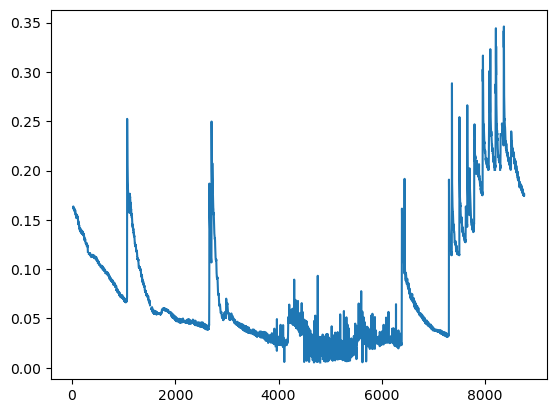

In [92]:
plt.plot(insitu_2022.ssm.values[:,valid_index][:,2])

In [ ]:
insitu_2022_6hr.ssm.values[:,valid_index][:,2]

array([       nan,        nan,        nan, ..., 0.22199999, 0.21913333,
       0.21825002], dtype=float32)

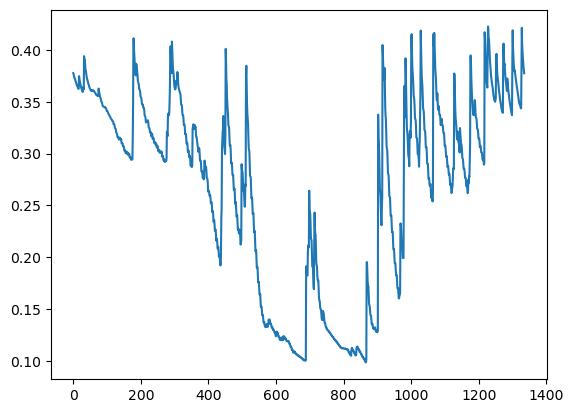

In [156]:
plt.plot(ailand_eval_2022.data.sel(variable='swvl1').values[:, x_idx4eval][:,2])

In [ ]:
# Workflow for selecting individual points from ailand output to evaluate -- using the find nearest helper function
# Step 1 -- find the nearest valid data point from the request dataset
request_lat=50
request_lon=5
target_array_lat=ailand_eval.lat.values
target_array_lon=ailand_eval.lon.values
x_idx,x_distance = find_nearest_idx(target_array_lat, target_array_lon, request_lat, request_lon)

In [ ]:
# Step 2 -- plot the time series at request location of the desired variable
plt.plot(ailand_eval_2022.data.sel(variable='swvl1').values[:, x_idx])

In [ ]:
# Step 3 -- calculate the acc or bias at the selected location


In [ ]:
# Step 4 -- plot and compare ailand and ecland model time series